# Outline

[M5 Forecasting - Accuracy](https://www.kaggle.com/c/m5-forecasting-accuracy/overview)  
Kaggle M5 competition: Walmart store forecasting for the Kaggle M5 (Accuracy) competition.   
The competition requires predicting store sales of individual items over a prediction period of 28 days.  
### Modeling
- LightGBM

### Metric  
- RMSE

### Date  
- Train data : 2012/1/27~ 2016/4/24  
- Validation data: 2016/4/25 ~ 2016/5/22   
- Test: 2016/5/23 ~ 2016/6/19  


### Features

 Demand:  
- lag [ 28+ 7*(1, 2, 3, 4, 5, 6, 7, 8, 12, 16, 20, 24, 28,  32,  40,  44,  48]   
- rolling mean - lag [ 28 ] rolling [7, 14 ,21, 28, 56]  

Sell_price:  
- rolling max - lag [ 1 ] rolling [365]  
- rolling std -  rolling [7,28]  
- price relative to rolling max  


## Import

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import dask.dataframe as dd
pd.set_option('display.max_columns', 500)
#pd.set_option('display.max_rows', 50)
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import lightgbm as lgb
from sklearn import preprocessing, metrics
from sklearn.preprocessing import LabelEncoder
import gc
import os
#from tqdm import tqdm
import joblib
import time 

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [2]:
# Function
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


## Read and cleaning data

In [3]:
def read_data():
    print('Reading files...')
    calendar = pd.read_csv('../input/m5-forecasting-accuracy/calendar.csv')
    calendar = reduce_mem_usage(calendar)
    print('Calendar has {} rows and {} columns'.format(calendar.shape[0], calendar.shape[1]))
    
    sell_prices = pd.read_csv('../input/m5-forecasting-accuracy/sell_prices.csv')
    sell_prices = reduce_mem_usage(sell_prices)
    
    print('Sell prices has {} rows and {} columns'.format(sell_prices.shape[0], sell_prices.shape[1]))
    
    #sales_train_val = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv') ##~d1913
    sales_train_val = pd.read_csv('../input/m5-forecasting-accuracy/sales_train_evaluation.csv') ##~d1941
    #sales_train_val = downcast(sales_train_val)
    print('Sales train validation has {} rows and {} columns'.format(sales_train_val.shape[0], sales_train_val.shape[1]))
    
    submission = pd.read_csv('../input/m5-forecasting-accuracy/sample_submission.csv')
    
    return calendar, sell_prices, sales_train_val, submission

calendar, sell_prices, sales_train_val, submission = read_data()

#number of items, and number of prediction period
print("number of items, and number of prediction period................")
NUM_ITEMS = sales_train_val.shape[0]  # 30490　
DAYS_PRED = submission.shape[1] - 1  # 28
print("NUM_ITEMS",NUM_ITEMS)
print("DAYS_PRED",DAYS_PRED)

Reading files...
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Calendar has 1969 rows and 14 columns
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Sell prices has 6841121 rows and 4 columns
Sales train validation has 30490 rows and 1947 columns
number of items, and number of prediction period................
NUM_ITEMS 30490
DAYS_PRED 28


##  Data preprocessing

Label encoding (object→category)

In [4]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [5]:
def encode_categorical(df, cols):
    
    for col in cols:
        # Leave NaN as it is.
        le = LabelEncoder()
        #not_null = df[col][df[col].notnull()]
        df[col] = df[col].fillna('nan')
        df[col] = pd.Series(le.fit_transform(df[col]), index=df.index)

    return df

calendar = encode_categorical(
    calendar, ["event_name_1", "event_type_1", "event_name_2", "event_type_2"]
).pipe(reduce_mem_usage)

sales_train_val = encode_categorical(
    sales_train_val, ["item_id", "dept_id", "cat_id", "store_id", "state_id"],
).pipe(reduce_mem_usage)

sell_prices = encode_categorical(sell_prices, ["item_id", "store_id"]).pipe(
    reduce_mem_usage
)



Mem. usage decreased to  0.07 Mb (24.5% reduction)
Mem. usage decreased to 95.14 Mb (79.0% reduction)
Mem. usage decreased to 45.67 Mb (41.7% reduction)


In [6]:
product = sales_train_val[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']].drop_duplicates()
product.head()

,id,item_id,dept_id,cat_id,store_id,state_id
0,HOBBIES_1_001_CA_1_evaluation,1437,3,1,0,0
1,HOBBIES_1_002_CA_1_evaluation,1438,3,1,0,0
2,HOBBIES_1_003_CA_1_evaluation,1439,3,1,0,0
3,HOBBIES_1_004_CA_1_evaluation,1440,3,1,0,0
4,HOBBIES_1_005_CA_1_evaluation,1441,3,1,0,0


# Melting the data

In [7]:
# to remove data before first non-zero demand date, replace these demand as np.nan.
#d_0~d_1941 evalution
d_name = ['d_' + str(i+1) for i in range(1941)]
sales_train_val_values = sales_train_val[d_name].values

# calculate the start position(first non-zero demand observed date) for each item / 商品の最初の売上日
tmp = np.tile(np.arange(1,1941+1),(sales_train_val_values.shape[0],1)) #(30490, 1941)
df_tmp = ((sales_train_val_values>0) * tmp) #売り上げ0の場合0にdを0にして埋める

start_no = np.min(np.where(df_tmp==0,9999,df_tmp),axis=1)-1

flag = np.dot(np.diag(1/(start_no+1)) , tmp)<1 

sales_train_val_values = np.where(flag,np.nan,sales_train_val_values)

sales_train_val[d_name] = sales_train_val_values

del tmp,sales_train_val_values, df_tmp

print("train_end_day", np.max(start_no)) #1845
print("valid+test_day", 1941-np.max(start_no)) #valid:36day, test:36day

gc.collect()

train_end_day 1845
valid+test_day 96


0

In [8]:
sales_train_val = pd.melt(sales_train_val,
                                     id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
                                     var_name = 'day', value_name = 'demand')
# display(sales_train_val.head(5))
# print('Melted sales train validation has {} rows and {} columns'.format(sales_train_val.shape[0],
#                                                                             sales_train_val.shape[1]))

sales_train_val = sales_train_val[~sales_train_val.demand.isnull()] #demandがNanを除外
sales_train_val.head()

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand
7,HOBBIES_1_008_CA_1_evaluation,1444,3,1,0,0,d_1,12.0
8,HOBBIES_1_009_CA_1_evaluation,1445,3,1,0,0,d_1,2.0
14,HOBBIES_1_015_CA_1_evaluation,1451,3,1,0,0,d_1,4.0
15,HOBBIES_1_016_CA_1_evaluation,1452,3,1,0,0,d_1,5.0
21,HOBBIES_1_022_CA_1_evaluation,1458,3,1,0,0,d_1,2.0


In [9]:
# seperate test dataframes

test1_rows = [row for row in submission['id'] if 'validation' in row]
test2_rows = [row for row in submission['id'] if 'evaluation' in row]

test1 = submission[submission['id'].isin(test1_rows)]
test2 = submission[submission['id'].isin(test2_rows)]

# test1, test2の列名の"F_X"の箇所をd_XXX"の形式に変更
test1.columns = ["id"] + [f"d_{d}" for d in range(1914, 1914 + DAYS_PRED)] #DAYS_PRED:28, test1:d_1914~1941
test2.columns = ["id"] + [f"d_{d}" for d in range(1942, 1942 + DAYS_PRED)] #test2:d_1942~d_1969

# test1のidの'_validtaion'に置換
test1['id'] = test1['id'].str.replace('_validation','_evaluation')


# # idをキーにして, idの詳細部分をtest1, test2に結合する.
test1 = test1.merge(product, how = 'left', on = 'id')
test2 = test2.merge(product, how = 'left', on = 'id')

# # test1, test2をともにmelt処理する.（売上数量:demandは0）
test1 = pd.melt(test1, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
                var_name = 'day', value_name = 'demand')

test2 = pd.melt(test2, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
                var_name = 'day', value_name = 'demand')

sales_train_val['part'] = 'train' #11106413
test1['part'] = 'test1'#853720
test2['part'] = 'test2'#853720

data = pd.concat([sales_train_val, test1, test2], axis = 0)


del sales_train_val, test1, test2,test1_rows, test2_rows

data = data[data['part'] != 'test1']

gc.collect()

14

## Merge data

In [10]:
#calendarの結合
# drop some calendar features
calendar.drop(['weekday', 'wday', 'month', 'year'], 
              inplace = True, axis = 1)

# notebook crash with the entire dataset (maybee use tensorflow, dask, pyspark xD)(dayとdをキーにdataに結合)
data = pd.merge(data, calendar, how = 'left', left_on = ['day'], right_on = ['d'])
#data.drop(['d', 'day'], inplace = True, axis = 1)
data.drop(['day'], inplace = True, axis = 1)


# memoryの開放
del  calendar
gc.collect()

#sell priceの結合
# get the sell price data (this feature should be very important)
data = data.merge(sell_prices, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')
print('Our final dataset to train has {} rows and {} columns'.format(data.shape[0], data.shape[1]))

# memoryの開放
del  sell_prices
gc.collect()

Our final dataset to train has 47648616 rows and 19 columns


28

In [11]:
# dを4桁表示に
def label_encdor(df):
    df.d = df['d'].apply(lambda x: x.split('_')[1]).astype(np.int16)           

    return df

data = label_encdor(data)

# Feature engineering

In [12]:
def create_features(df):
    DAYS_PRED = 28
    
    # lag featur
    diffs = [0, 1, 2, 3, 4, 5, 6]
    for diff in diffs:
        s = DAYS_PRED + diff
        df[f"demand_lag_t{s}"] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],as_index=False)['demand'].shift(s).astype(np.float16)
        
    #曜日毎、1年前まで
    weeks = [1,2,3,4,5,6,7,8, 12,16,20,24,28, 32, 40, 44, 48] #48*7 =336day, 336day+28day=364day
    for week in weeks: #28日前から48週間
        s =  DAYS_PRED +(week *7 ) #day28*13 = 355day (355day-28day)/7=46.7week
        df[f"demand_lag_t{s}"] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],as_index=False)['demand'].shift(s).astype(np.float16)
        
        
    #　7+28日前の28日間移動平均
    df['lag_t7_28mean'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['demand'].transform(lambda x: x.shift(DAYS_PRED+7).rolling(DAYS_PRED).mean().astype(np.float16))

    # 28lag+rolling window
    for size in [7, 14 ,21, 28, 56]: #56
        df[f"rolling_mean_t{size}"] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['demand'].transform(lambda x: x.shift(DAYS_PRED).rolling(size).mean().astype(np.float16))
    
    #  28lag+expanding window
    for size in [7, 14 ,21, 28, 56]: #56
        df[f"expanding_mean_t{size}"] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['demand'].transform(lambda x: x.shift(DAYS_PRED).expanding(size).mean().astype(np.float16))
    
    
    # price features
    
    df["shift_price_t1"] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])["sell_price"].transform(
        lambda x: x.shift(1)
    )
    df["price_change_t1"] = (df["shift_price_t1"] - df["sell_price"]) / (
        df["shift_price_t1"]
    )
    df["rolling_price_max_t365"] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])["sell_price"].transform(
        lambda x: x.shift(1).rolling(365).max()
    )
    df["price_change_t365"] = (df["rolling_price_max_t365"] - df["sell_price"]) / (
        df["rolling_price_max_t365"]
    )

    df["rolling_price_std_t7"] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])["sell_price"].transform(
        lambda x: x.rolling(7).std()
    )
    df["rolling_price_std_t28"] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])["sell_price"].transform(
        lambda x: x.rolling(28).std()
    )
    
    
    
    # 日付に関するデータ
    dt_col = "date"
    data[dt_col] = pd.to_datetime(data[dt_col])
    
    attrs = [
        "year",
        "month",
        "week",
        "day",
        "dayofweek",
    ]

    for attr in attrs:
        dtype = np.int16 if attr == "year" else np.int8
        data[attr] = getattr(data[dt_col].dt, attr).astype(dtype)

    data["is_weekend"] = data["dayofweek"].isin([5, 6]).astype(np.int8)

    return df

#data = create_features(data)

In [13]:
# feature
t1 = time.time() 
data = create_features(data)
data = reduce_mem_usage(data)
t2 = time.time()
 
elapsed_time = t2-t1
print(f"sec：{elapsed_time}")

Mem. usage decreased to 6452.66 Mb (4.1% reduction)
sec：1892.1630239486694


In [14]:
#saved
data.to_pickle('data_pre_model.pkl')
# del df
# gc.collect();

# Model train

hold-out
train : 2012/1/27~ 2016/4/24, d_364~d_1914  
valid : 2016/4/25 ~ 2016/5/22, d_1914~d_1941  
test  : 2016/5/23 ~ 2016/6/19, d_1942~d_1969    

In [15]:
data = data[data['d'] >= 364]
data.tail()

,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,demand_lag_t28,demand_lag_t29,demand_lag_t30,demand_lag_t31,demand_lag_t32,demand_lag_t33,demand_lag_t34,demand_lag_t35,demand_lag_t42,demand_lag_t49,demand_lag_t56,demand_lag_t63,demand_lag_t70,demand_lag_t77,demand_lag_t84,demand_lag_t112,demand_lag_t140,demand_lag_t168,demand_lag_t196,demand_lag_t224,demand_lag_t252,demand_lag_t308,demand_lag_t336,demand_lag_t364,lag_t7_28mean,rolling_mean_t7,rolling_mean_t14,rolling_mean_t21,rolling_mean_t28,rolling_mean_t56,expanding_mean_t7,expanding_mean_t14,expanding_mean_t21,expanding_mean_t28,expanding_mean_t56,shift_price_t1,price_change_t1,rolling_price_max_t365,price_change_t365,rolling_price_std_t7,rolling_price_std_t28,year,month,week,day,dayofweek,is_weekend
47648611,FOODS_3_823_WI_3_evaluation,1432,2,0,9,2,0.0,test2,2016-06-19,11621,1969,16,3,2,0,0,0,0,2.980469,1.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,1.0,1.0,2.0,0.0,0.571289,0.571289,0.643066,0.666504,0.643066,0.428467,0.536133,0.536133,0.536133,0.536133,0.536133,2.980469,0.0,2.980469,0.0,0.000000e+00,0.000000e+00,2016,6,24,19,6,1
47648612,FOODS_3_824_WI_3_evaluation,1433,2,0,9,2,0.0,test2,2016-06-19,11621,1969,16,3,2,0,0,0,0,2.480469,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.285645,0.142822,0.238037,0.285645,0.303467,0.375977,0.375977,0.375977,0.375977,0.375977,2.480469,0.0,2.480469,0.0,5.960464e-08,0.000000e+00,2016,6,24,19,6,1
47648613,FOODS_3_825_WI_3_evaluation,1434,2,0,9,2,0.0,test2,2016-06-19,11621,1969,16,3,2,0,0,0,0,3.980469,2.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.714355,0.856934,1.000000,0.809570,0.785645,0.839355,0.894043,0.894043,0.894043,0.894043,0.894043,3.980469,0.0,3.980469,0.0,0.000000e+00,5.960464e-08,2016,6,24,19,6,1
47648614,FOODS_3_826_WI_3_evaluation,1435,2,0,9,2,0.0,test2,2016-06-19,11621,1969,16,3,2,0,0,0,0,1.280273,0.0,1.0,1.0,1.0,0.0,6.0,4.0,1.0,1.0,0.0,3.0,1.0,2.0,1.0,4.0,0.0,3.0,1.0,5.0,4.0,0.0,0.0,2.0,0.0,1.142578,1.857422,1.428711,1.380859,1.321289,1.125000,0.737305,0.737305,0.737305,0.737305,0.737305,1.280273,0.0,1.280273,0.0,0.000000e+00,0.000000e+00,2016,6,24,19,6,1
47648615,FOODS_3_827_WI_3_evaluation,1436,2,0,9,2,0.0,test2,2016-06-19,11621,1969,16,3,2,0,0,0,0,1.000000,1.0,5.0,2.0,2.0,0.0,4.0,5.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,5.0,0.0,1.0,0.0,0.0,0.0,2.0,4.0,1.0,5.0,0.571289,2.714844,1.642578,1.571289,1.250000,1.161133,1.681641,1.681641,1.681641,1.681641,1.681641,1.000000,0.0,1.000000,0.0,0.000000e+00,0.000000e+00,2016,6,24,19,6,1


In [16]:
valid = data[(data['d']>=1914) & (data['d']<1942)][['id','d','demand']]
test = data[data['d']>=1942][['id','d','demand']]
eval_preds = test['demand']
valid_preds = valid['demand'].copy()

In [17]:
useless_cols = ["id", "part","demand" ,"date", "wm_yr_wk"]
features = data.columns[~data.columns.isin(useless_cols)]
features.tolist()

['item_id',
 'dept_id',
 'cat_id',
 'store_id',
 'state_id',
 'd',
 'event_name_1',
 'event_type_1',
 'event_name_2',
 'event_type_2',
 'snap_CA',
 'snap_TX',
 'snap_WI',
 'sell_price',
 'demand_lag_t28',
 'demand_lag_t29',
 'demand_lag_t30',
 'demand_lag_t31',
 'demand_lag_t32',
 'demand_lag_t33',
 'demand_lag_t34',
 'demand_lag_t35',
 'demand_lag_t42',
 'demand_lag_t49',
 'demand_lag_t56',
 'demand_lag_t63',
 'demand_lag_t70',
 'demand_lag_t77',
 'demand_lag_t84',
 'demand_lag_t112',
 'demand_lag_t140',
 'demand_lag_t168',
 'demand_lag_t196',
 'demand_lag_t224',
 'demand_lag_t252',
 'demand_lag_t308',
 'demand_lag_t336',
 'demand_lag_t364',
 'lag_t7_28mean',
 'rolling_mean_t7',
 'rolling_mean_t14',
 'rolling_mean_t21',
 'rolling_mean_t28',
 'rolling_mean_t56',
 'expanding_mean_t7',
 'expanding_mean_t14',
 'expanding_mean_t21',
 'expanding_mean_t28',
 'expanding_mean_t56',
 'shift_price_t1',
 'price_change_t1',
 'rolling_price_max_t365',
 'price_change_t365',
 'rolling_price_std_t7',


In [18]:
#店舗毎に学習
import lightgbm as lgb
import joblib

stores = data['store_id'].unique().tolist() #[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
d_store_id ={0: 'CA_1',1: 'CA_2', 2: 'CA_3', 3: 'CA_4', 4: 'TX_1',  5: 'TX_2', 6: 'TX_3', 7: 'WI_1', 8: 'WI_2', 9: 'WI_3'}
for store in stores:
    #Split the data
    X_train, y_train = data[(data['store_id'] == store) & (data['d'] < 1914) ][features], data[(data['store_id'] == store) & (data['d'] < 1914) ]['demand']
    X_valid, y_valid = data[(data['store_id'] == store) & (data['d']>=1914) & (data['d']<1942)][features], data[(data['store_id'] == store) & (data['d']>=1914) & (data['d']<1942)]['demand']
    X_test = data[(data['store_id'] == store) & (data['d'] >=1942) ][features]
    
    
    #lgb data
    train_set = lgb.Dataset(X_train, y_train)
    val_set = lgb.Dataset(X_valid, y_valid)
    
    
    #paramas
    
    params = {
                "objective" : "poisson",
                "metric" :"rmse",
                "force_row_wise" : True,
                "learning_rate" : 0.075,
        #         "sub_feature" : 0.8,
                "sub_row" : 0.75,
                "bagging_freq" : 1,
                "lambda_l2" : 0.1,
        #         "nthread" : 4
                "metric": ["rmse"],
            'verbosity': 1,
            'num_iterations' : 1200,
            'num_leaves': 128,
            "min_data_in_leaf": 100,
        }
    # model train
    print('*****Prediction for Store: {}*****'.format(d_store_id[store]))
    model = lgb.train(params, train_set, num_boost_round = 1000, early_stopping_rounds = 50,
                      valid_sets = [train_set, val_set], verbose_eval = 100)
    
    valid_preds[X_valid.index] = model.predict(X_valid)
    eval_preds[X_test.index] = model.predict(X_test)
    filename = 'model'+str(d_store_id[store])+'.pkl'

    
    # save model
    joblib.dump(model, filename)
    del model, X_train, y_train, X_valid, y_valid, train_set, val_set
    
    gc.collect()

*****Prediction for Store: CA_1*****


C:\Users\reEoN\Anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[100]	training's rmse: 2.56054	valid_1's rmse: 2.26655
Early stopping, best iteration is:
[121]	training's rmse: 2.53631	valid_1's rmse: 2.2616
*****Prediction for Store: CA_2*****


C:\Users\reEoN\Anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[100]	training's rmse: 2.05551	valid_1's rmse: 2.08965
[200]	training's rmse: 2.00045	valid_1's rmse: 2.06482
[300]	training's rmse: 1.95773	valid_1's rmse: 2.05449
[400]	training's rmse: 1.92494	valid_1's rmse: 2.0507
Early stopping, best iteration is:
[405]	training's rmse: 1.92312	valid_1's rmse: 2.04969
*****Prediction for Store: CA_3*****


C:\Users\reEoN\Anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[100]	training's rmse: 3.55445	valid_1's rmse: 2.61373
Early stopping, best iteration is:
[64]	training's rmse: 3.64582	valid_1's rmse: 2.60365
*****Prediction for Store: CA_4*****


C:\Users\reEoN\Anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[100]	training's rmse: 1.53002	valid_1's rmse: 1.455
[200]	training's rmse: 1.49518	valid_1's rmse: 1.44991
[300]	training's rmse: 1.46623	valid_1's rmse: 1.44701
[400]	training's rmse: 1.44545	valid_1's rmse: 1.44588
[500]	training's rmse: 1.42617	valid_1's rmse: 1.44528
[600]	training's rmse: 1.40923	valid_1's rmse: 1.44486
Early stopping, best iteration is:
[569]	training's rmse: 1.4143	valid_1's rmse: 1.44465
*****Prediction for Store: TX_1*****


C:\Users\reEoN\Anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[100]	training's rmse: 2.10375	valid_1's rmse: 1.80873
[200]	training's rmse: 2.01834	valid_1's rmse: 1.80369
[300]	training's rmse: 1.95688	valid_1's rmse: 1.79835
Early stopping, best iteration is:
[305]	training's rmse: 1.95421	valid_1's rmse: 1.79787
*****Prediction for Store: TX_2*****


C:\Users\reEoN\Anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[100]	training's rmse: 2.56374	valid_1's rmse: 2.01085
[200]	training's rmse: 2.44954	valid_1's rmse: 2.0002
[300]	training's rmse: 2.3583	valid_1's rmse: 1.99141
[400]	training's rmse: 2.28914	valid_1's rmse: 1.99172
Early stopping, best iteration is:
[370]	training's rmse: 2.30964	valid_1's rmse: 1.99054
*****Prediction for Store: TX_3*****


C:\Users\reEoN\Anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[100]	training's rmse: 2.22744	valid_1's rmse: 2.16843
[200]	training's rmse: 2.13471	valid_1's rmse: 2.15505
[300]	training's rmse: 2.06898	valid_1's rmse: 2.14864
[400]	training's rmse: 2.01607	valid_1's rmse: 2.1458
Early stopping, best iteration is:
[370]	training's rmse: 2.03219	valid_1's rmse: 2.14363
*****Prediction for Store: WI_1*****


C:\Users\reEoN\Anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[100]	training's rmse: 1.77223	valid_1's rmse: 1.73968
[200]	training's rmse: 1.72495	valid_1's rmse: 1.72547
[300]	training's rmse: 1.68984	valid_1's rmse: 1.71934
[400]	training's rmse: 1.6618	valid_1's rmse: 1.71797
[500]	training's rmse: 1.63912	valid_1's rmse: 1.71645
Early stopping, best iteration is:
[527]	training's rmse: 1.6339	valid_1's rmse: 1.71532
*****Prediction for Store: WI_2*****


C:\Users\reEoN\Anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[100]	training's rmse: 2.83819	valid_1's rmse: 3.03981
Early stopping, best iteration is:
[117]	training's rmse: 2.81154	valid_1's rmse: 3.03874
*****Prediction for Store: WI_3*****


C:\Users\reEoN\Anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[100]	training's rmse: 2.35926	valid_1's rmse: 2.12772
[200]	training's rmse: 2.24414	valid_1's rmse: 2.12337
[300]	training's rmse: 2.15868	valid_1's rmse: 2.11454
Early stopping, best iteration is:
[331]	training's rmse: 2.13679	valid_1's rmse: 2.11


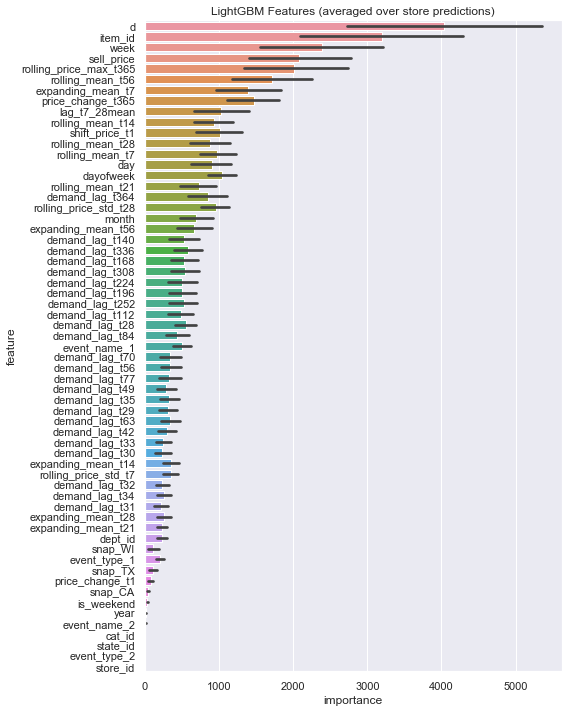

In [19]:
import seaborn as sns

feature_importance_df = pd.DataFrame()
#features = [f for f in data.columns if f != ['id', 'part', 'date','demand']]
# for filename in os.listdir('/kaggle/working/'):
#     if 'model' in filename:

filenames = ['modelCA_1.pkl', 'modelCA_2.pkl', 'modelCA_3.pkl','modelCA_4.pkl',
            'modelTX_1.pkl', 'modelTX_2.pkl', 'modelTX_3.pkl',
            'modelWI_1.pkl', 'modelWI_2.pkl', 'modelWI_3.pkl',]
for filename in filenames:
        # load model
        model = joblib.load(filename)
        store_importance_df = pd.DataFrame()
        store_importance_df["feature"] = features
        store_importance_df["importance"] = model.feature_importance()
        store_importance_df["store"] = filename[5:9]
        feature_importance_df = pd.concat([feature_importance_df, store_importance_df], axis=0)
    
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (averaged over store predictions)')
    plt.tight_layout()
    
display_importances(feature_importance_df)

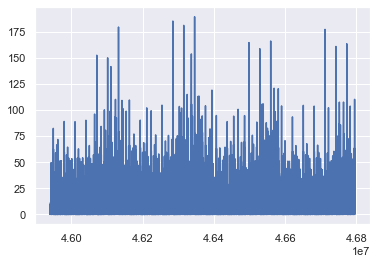

In [20]:
plt.plot(np.clip(valid_preds,0, None ))

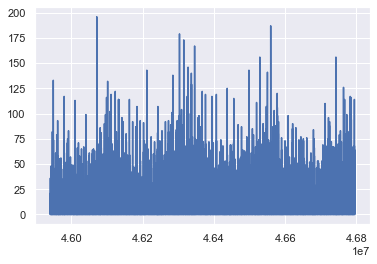

In [21]:
plt.plot(valid['demand'])

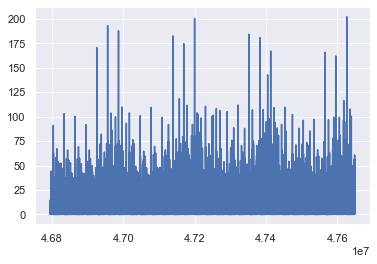

In [22]:
plt.plot(eval_preds)

### Submission

In [23]:
valid['demand'] = np.clip(valid_preds,0, None )
validation = valid[['id', 'd', 'demand']]
validation = pd.pivot(validation, index='id', columns='d', values='demand').reset_index()
validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
validation.id = validation['id'].str.replace('_evaluation','_validation')

test['demand'] = eval_preds
evaluation = test[['id', 'd', 'demand']]
evaluation = pd.pivot(evaluation, index='id', columns='d', values='demand').reset_index()
evaluation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]

In [24]:
submit = pd.concat([validation,evaluation]).reset_index(drop=True)
submit.to_csv('submission_20200704.csv',index=False)

Private Score:0.57457
Public Score:0.60214